# gwexpy TimeSeries 新機能チュートリアル

このノートブックでは、`gwpy` を拡張した `gwexpy` の `TimeSeries` クラスに追加された新しいメソッドとその使い方を解説します。

`gwexpy` は GWpy との高い互換性を維持しつつ、信号処理、統計解析、他ライブラリとの相互運用性を大幅に強化しています。

## 目次
1. [環境セットアップ](#setup)
2. [信号処理と復調 (Hilbert, Phase, Demodulation)](#signal-processing)
3. [スペクトル解析と相関 (FFT, Transfer Function, xcorr)](#spectral)
4. [統計・前処理 (Impute, Standardize, ARIMA, Hurst, Rolling)](#stats)
5. [リサンプリングと再インデックス (asfreq, resample)](#resampling)
6. [相互運用性 (Pandas, Xarray, Torch, and more)](#interop)

<a id="setup"></a>
## 1. 環境セットアップ

まずは必要なライブラリをインポートし、デモ用のサンプルデータを生成します。

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from gwexpy.timeseries import TimeSeries
from gwexpy.plot import Plot
from astropy import units as u
from gwexpy.noise.wave import sine, gaussian, chirp, exponential

# サンプルデータの生成 (100Hzでサンプリングされた5秒間のデータ)
fs = 100
duration = 5.0
# Restore 't' for compatibility with downstream cells if they use it
t = np.arange(0, duration, 1/fs)

# Sensor 1: 10Hzの正弦波 + ノイズ
s1 = sine(duration=duration, sample_rate=fs, frequency=10, amplitude=1.0)
n1 = gaussian(duration=duration, sample_rate=fs, std=0.2)
ts1 = s1 + n1
ts1.name = 'Sensor 1'
ts1.override_unit('V')

# Sensor 2: チャープ信号 (周波数が時間とともに変化: 5Hz -> 25Hz) + 指数関数的な増幅
s2 = chirp(duration=duration, sample_rate=fs, f0=5, f1=25, t1=duration)
env = exponential(duration=duration, sample_rate=fs, tau=2.0, decay=False, amplitude=0.2)
ts2 = s2 * env
ts2.name = 'Chirp Signal'
ts2.override_unit('V')


<a id="signal-processing"></a>
## 2. 信号処理と復調

`gwexpy` では、ヒルベルト変換や包絡線、瞬時周波数の計算、さらにロックインアンプのような復調機能が統合されています。

### ヒルベルト変換と包絡線
`hilbert` と `envelope` を使用します。

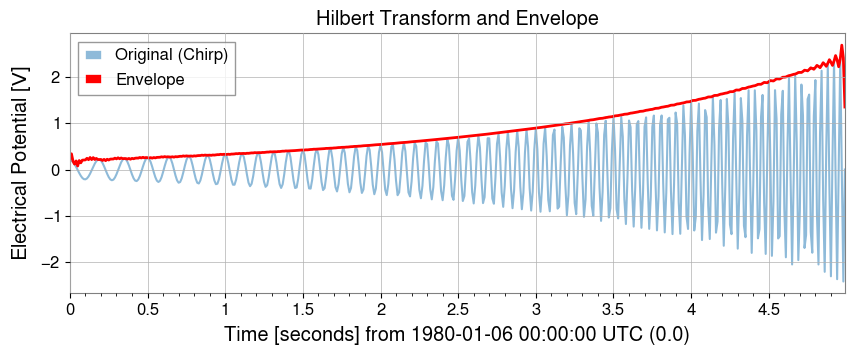

In [41]:
# 分析信号 (Analytic Signal) の計算
ts_analytic = ts2.hilbert()
# 包絡線 (Envelope) の計算
ts_env = ts2.envelope()

plot = Plot(ts2, ts_env, figsize=(10, 4))
ax = plot.gca()
ax.get_lines()[0].set_label('Original (Chirp)')
ax.get_lines()[0].set_alpha(0.5)
ax.get_lines()[1].set_label('Envelope')
ax.get_lines()[1].set_color('red')
ax.get_lines()[1].set_linewidth(2)
ax.legend()
ax.set_title('Hilbert Transform and Envelope')
plt.show()

### 瞬時位相と瞬時周波数
`instantaneous_phase` と `instantaneous_frequency` を使用します。位相のアンラップ (`unwrap`) や度の単位 (`deg`) も指定可能です。

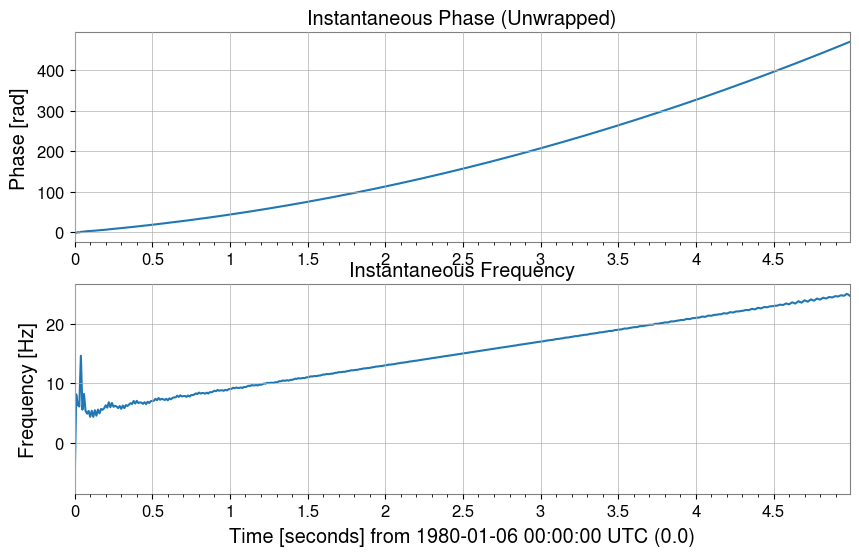

In [42]:
# 瞬時位相 (unwrap=True で位相跳びを解消)
phase_rad = ts2.instantaneous_phase(unwrap=True)
phase_deg = ts2.instantaneous_phase(deg=True, unwrap=True)

# 瞬時周波数
freq = ts2.instantaneous_frequency()

plot = Plot(phase_rad, freq, separate=True, sharex=True, figsize=(10, 6))
ax = plot.axes
ax[0].set_ylabel('Phase [rad]')
ax[0].set_title('Instantaneous Phase (Unwrapped)')
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_title('Instantaneous Frequency')
plt.show()

### 混合と復調 (Mix-down, Baseband, Lock-in)
特定の周波数成分を抽出したり、直流成分へ落とし込むための機能です。

TimeSeries([1.0417822 , 0.92949607, 0.96285482, 0.94259813,
            0.99254535, 0.96545348, 0.9561352 , 1.11112538,
            1.00098097, 1.03225848, 0.99893083, 1.09079399,
            0.94430734, 0.82710606, 1.15205248, 1.06170681,
            1.03108475, 1.08284164, 0.99813767, 0.9435449 ,
            0.99902335, 0.94534987, 1.10282359, 0.81547597,
            1.10508335, 1.10957751, 1.01284926, 1.04236776,
            0.96306824, 0.90932274, 0.89320549, 1.09590878,
            0.86345476, 1.11279054, 0.91526059, 1.04374085,
            0.97219142, 0.94208686, 1.05902268, 1.19041494,
            0.95546326, 1.02323618, 1.16985183, 0.98254786,
            0.94937227, 1.06370259, 1.02979766, 1.02012262,
            1.04915105, 0.99618931]
           unit: V,
           t0: 0.0 s,
           dt: 0.1 s,
           name: Sensor 1,
           channel: None)


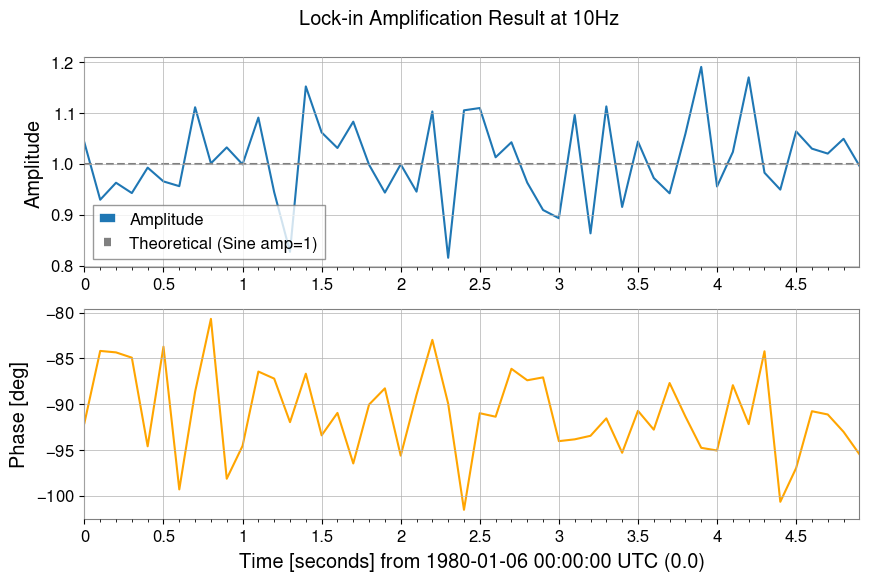

In [43]:
# 1. mix_down: 特定の周波数 f0 で複調 (複素信号になる)
ts_mixed = ts1.mix_down(f0=10)

# 2. baseband: demodulation + lowpass + resampling を一括実行
ts_base = ts1.baseband(f0=10, lowpass=5, output_rate=20)

# 3. lock_in: ロックイン検波 (振幅と位相を抽出)
amp, ph = ts1.lock_in(f0=10, stride=0.1) # 0.1秒ごとの平均を出力
res_complex = ts1.lock_in(f0=10, stride=0.1, output='complex') # 複素数での出力

print(amp)

plot = Plot(amp, ph, separate=True, sharex=True, figsize=(10, 6))
ax = plot.axes
ax[0].get_lines()[0].set_label('Amplitude')
ax[0].axhline(1.0, color='gray', linestyle='--', label='Theoretical (Sine amp=1)')
ax[0].set_ylabel('Amplitude')
ax[0].legend()
ax[1].get_lines()[0].set_color('orange')
ax[1].get_lines()[0].set_label('Phase [deg]')
ax[1].set_ylabel('Phase [deg]')
plot.figure.suptitle('Lock-in Amplification Result at 10Hz')
plt.show()

<a id="spectral"></a>
## 3. スペクトル解析と相関

GWpy の機能を継承しつつ、過渡信号向けの `transient` モード FFT や、FFT の直接比による伝達関数計算が追加されています。

### 拡張された FFT
`mode="transient"` を使用すると、ゼロパディングや高速な長さへの調整、左右個別のパディング指定が可能です。

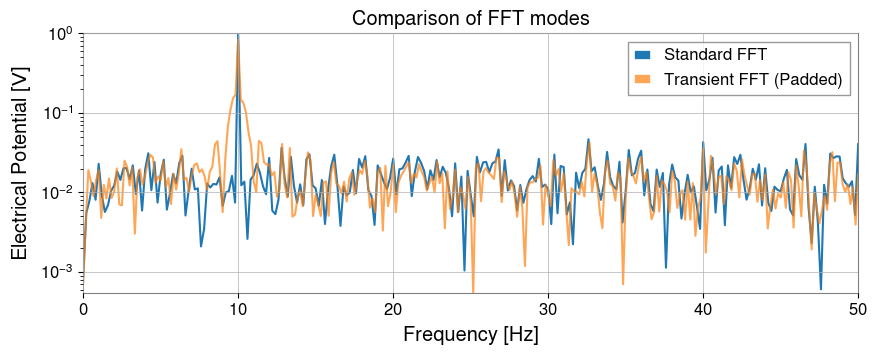

In [44]:
# 通常の FFT (GWpy互換)
fs_gwpy = ts1.fft()

# Transient モード:
# pad_left/right でパディング量を指定。nfft_mode="next_fast_len" で計算効率の良い長さに調整。
fs_trans = ts1.fft(mode="transient", pad_left=0.5, pad_right=0.5, nfft_mode="next_fast_len")

plot = Plot(fs_gwpy.abs(), fs_trans.abs(), yscale='log', xlim=(0, 50), figsize=(10, 4))
ax = plot.gca()
ax.get_lines()[0].set_label('Standard FFT')
ax.get_lines()[1].set_label('Transient FFT (Padded)')
ax.get_lines()[1].set_alpha(0.7)
ax.legend()
ax.set_title('Comparison of FFT modes')
plt.show()

### 伝達関数 (Transfer Function) と相互相関 (xcorr)
`transfer_function` では Welch法 (`method="gwpy"`) だけでなく、FFT の直接比 (`method="fft"`) も選択できます。

/tmp/ipykernel_27279/1615014204.py:3: DeprecationWarning: The 'method' parameter is deprecated. Use 'mode' instead: 'gwpy'/'csd_psd' -> mode='steady', 'fft' -> mode='transient'.
  tf_fft = ts2.transfer_function(ts1, method="fft") # 全区間FFT比 (過渡応答解析などに有用)


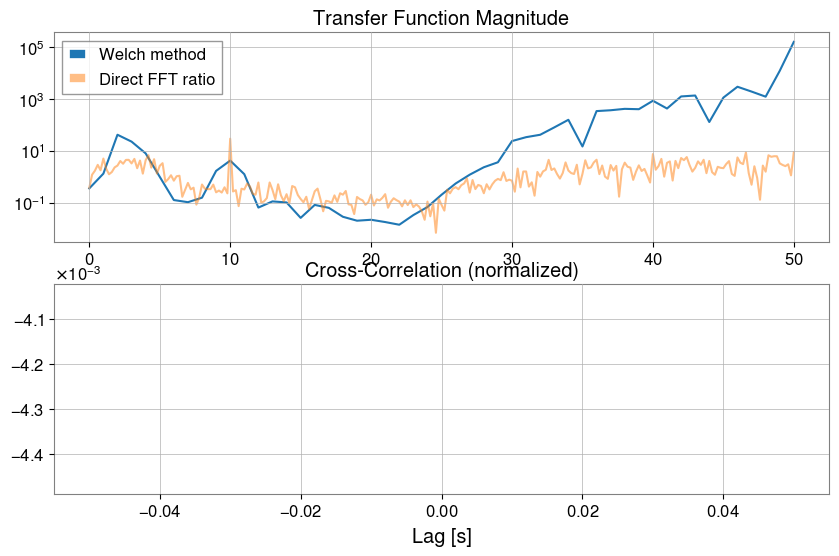

In [45]:
# 伝達関数の計算 (Sensor 1 に対する Chirp Signal の伝達関数)
tf_welch = ts2.transfer_function(ts1, fftlength=1)
tf_fft = ts2.transfer_function(ts1, method="fft") # 全区間FFT比 (過渡応答解析などに有用)

# 相互相関 (xcorr)
corr = ts1.xcorr(ts2, maxlag=0.5, normalize='coeff')

plot = Plot(figsize=(10, 6))
ax1 = plot.add_subplot(2, 1, 1)
ax1.semilogy(tf_welch.frequencies, np.abs(tf_welch), label='Welch method')
ax1.semilogy(tf_fft.frequencies, np.abs(tf_fft), label='Direct FFT ratio', alpha=0.5)
ax1.set_title('Transfer Function Magnitude')
ax1.legend()

ax2 = plot.add_subplot(2, 1, 2)
lag = corr.times.value - corr.t0.value
ax2.plot(lag, corr)
ax2.set_title('Cross-Correlation (normalized)')
ax2.set_xlabel('Lag [s]')
plt.show()

### STLT (Short-Time Laplace Transform)

STLT (Short-Time Laplace Transform) は、信号の時間変化に伴う局所的な構造（対称な2軸を持つ特徴量）を抽出するための変換です。
`gwexpy` では、このような3Dデータ (時間 x 軸1 x 軸2) を扱うために `TimePlaneTransform` クラスを提供しています。

以下は、`stlt` メソッドを使用して STLT を計算し、特定時刻のスライス (`Plane2D`) を抽出する例です。

In [46]:
# データの準備 (デモ用)
import numpy as np
from gwexpy.timeseries import TimeSeries
from gwexpy.plot import Plot

t = np.linspace(0, 10, 1000)
data = TimeSeries(np.sin(2 * np.pi * 1 * t), times=t*u.s, unit='V', name='Demo Data')

# STLT の実行
# stride: 時間ステップ, window: 解析ウィンドウ長
stlt_result = data.stlt(stride='0.5s', window='2s')

print(f"Kind: {stlt_result.kind}")
print(f"Shape: {stlt_result.shape} (Time x Axis1 x Axis2)")
print(f"Time Axis: {len(stlt_result.times)} steps")

# 特定時刻 (t=5.0s) の平面を抽出
plane_at_5s = stlt_result.at_time(5.0 * u.s)
print(f"Plane at 5.0s shape: {plane_at_5s.shape}")

# Plane2D としての振る舞いを確認
print(f"Axis 1: {plane_at_5s.axis1.name}")
print(f"Axis 2: {plane_at_5s.axis2.name}")

Kind: stlt
Shape: (17, 1, 101) (Time x Axis1 x Axis2)
Time Axis: 17 steps
Plane at 5.0s shape: (1, 101)
Axis 1: sigma
Axis 2: frequency


## 4. Hilbert-Huang Transform (HHT)
非線形・非定常信号解析のためのヒルベルト・ファン変換 (HHT) 機能です。
Empirical Mode Decomposition (EMD) とヒルベルトスペクトル解析を組み合わせます。

Extracted IMFs: ['IMF1', 'IMF2', 'IMF3', 'residual']


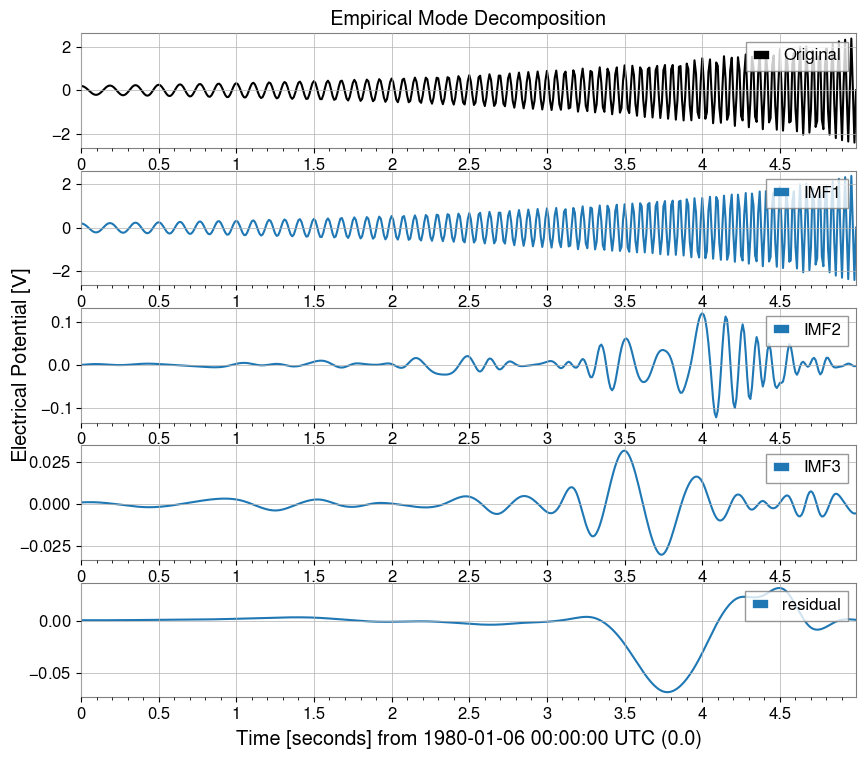

In [47]:
# HHT (Hilbert-Huang Transform)
# Empirical Mode Decomposition (EMD) を実行し、IMFs (Intrinsic Mode Functions) を抽出
# 注意: 実行には PyEMD (EMD-signal) が必要です: `pip install EMD-signal`

try:
    # EMDの実行 (戻り値は辞書)
    # method="emd" (標準EMD) または "eemd" (Ensemble EMD)
    # ここでは ts2 (Chirp信号を含む例) を使用します
    imfs = ts2.emd(method="emd", max_imf=3)

    print(f"Extracted IMFs: {list(imfs.keys())}")

    # IMFのプロット
    sorted_keys = sorted([k for k in imfs.keys() if k.startswith("IMF")], key=lambda x: int(x[3:]))
    if "residual" in imfs:
        sorted_keys.append("residual")

    # gwexpy.plot.Plot を使用して一括プロット
    plot_data = [ts2] + [imfs[k] for k in sorted_keys]
    plot = Plot(*plot_data, separate=True, sharex=True, figsize=(10, 8))

    # Originalの設定
    ax0 = plot.axes[0]
    ax0.get_lines()[0].set_label("Original")
    ax0.get_lines()[0].set_color('black')
    ax0.legend(loc="upper right")
    ax0.set_title("Empirical Mode Decomposition")

    # IMFsの設定
    for i, key in enumerate(sorted_keys):
        ax = plot.axes[i+1]
        ax.get_lines()[0].set_label(key)
        ax.legend(loc="upper right")

    plt.show()

except ImportError:
    print("EMD-signal not installed. Skipping HHT demo.")
except Exception as e:
    print(f"HHT Error: {e}")


<a id="stats"></a>
## 5. 統計・前処理

欠損値補完、標準化、ARIMAモデル、ハースト指数、およびローリング統計量が TimeSeries メソッドとして利用可能です。

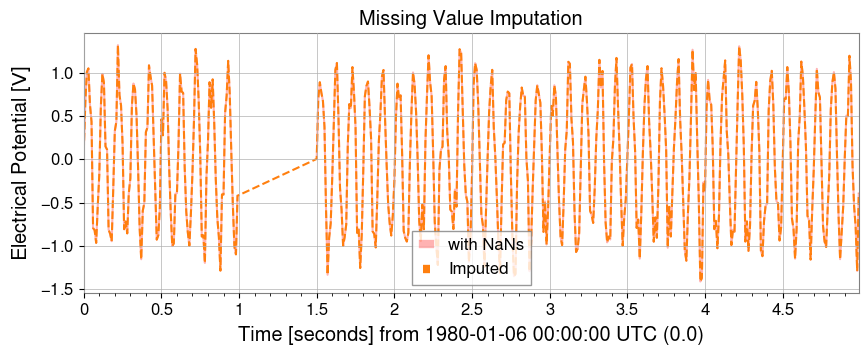

In [48]:
# 欠損値を含むデータのテスト
ts_nan = ts1.copy()
ts_nan.value[100:150] = np.nan

# 1. impute: 欠損値補完 (interpolation など)
ts_imputed = ts_nan.impute(method='interpolate')

# 2. standardize: 標準化 (z-score, robust など)
ts_z = ts1.standardize(method='zscore')
ts_robust = ts1.standardize(method='zscore', robust=True) # Median/IQRを使用

plot = Plot(ts_nan, ts_imputed, figsize=(10, 4))
ax = plot.gca()
ax.get_lines()[0].set_label('with NaNs')
ax.get_lines()[0].set_color('red')
ax.get_lines()[0].set_alpha(0.3)
ax.get_lines()[1].set_label('Imputed')
ax.get_lines()[1].set_linestyle('--')
ax.legend()
ax.set_title('Missing Value Imputation')
plt.show()

### ピーク検出 (Find Peaks)
`scipy.signal.find_peaks` をラップし、時系列データからピークを検出します。

Found 9 peaks
First 5 peaks: TimeSeries([0.25680508, 0.32974425, 0.44255219, 0.58570943,
            0.81881855]
           unit: V,
           t0: 0.5 s,
           dt: 0.5 s,
           name: Chirp Signal_peaks,
           channel: None)


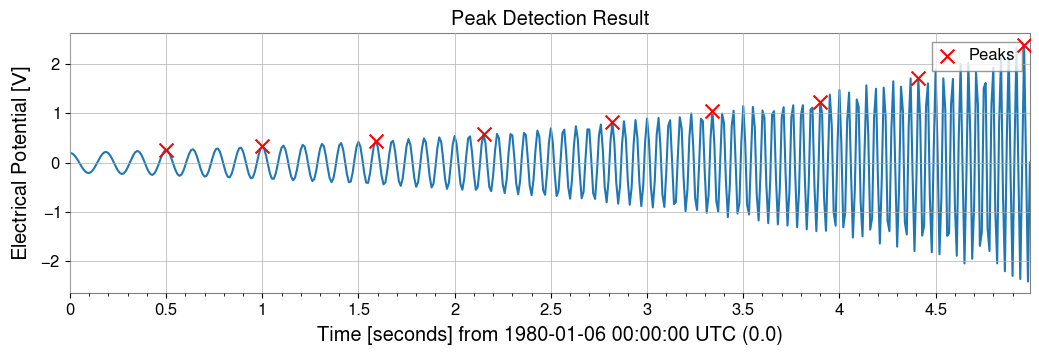

In [49]:
# ピーク検出 (Find Peaks)
# height, threshold, distance, prominence, width などのパラメータを指定可能
# 単位付きの閾値指定も可能です

# ts2 (Chirp + Sine) からピークを探す
peaks, props = ts2.find_peaks(height=0.0, distance=50)

print(f"Found {len(peaks)} peaks")
if len(peaks) > 0:
    print("First 5 peaks:", peaks[:5])

# プロット
plot = ts2.plot(figsize=(12, 4))
ax = plot.gca()
ax.scatter(peaks.times.value, peaks.value, marker="x", color="red", s=100, label="Peaks", zorder=10)
ax.legend(loc="upper right")
ax.set_title("Peak Detection Result")
plt.show()



### ARIMAモデルとハースト指数
※ これらの機能には `statsmodels`, `hurst` 等のライブラリが必要です。

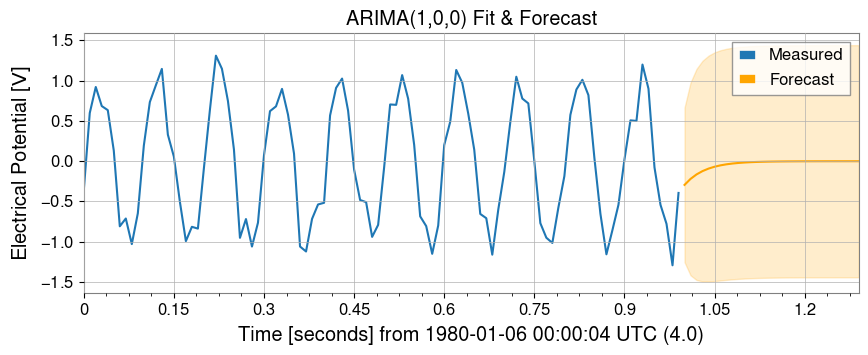

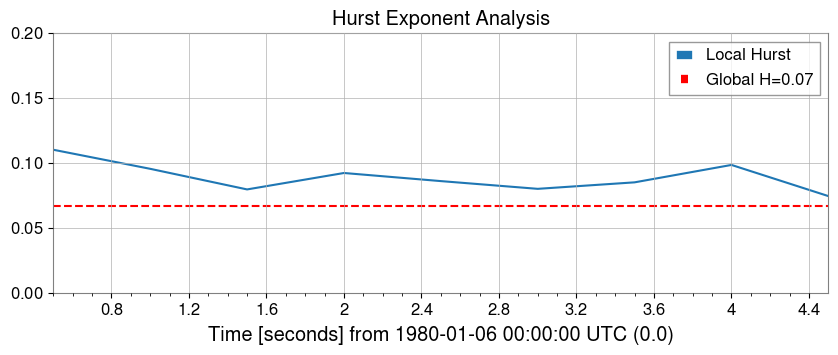

In [50]:
try:
    # 3. fit_arima: ARIMA(1,0,0) フィッティングと予測
    model = ts1.fit_arima(order=(1, 0, 0))
    resid = model.residuals()
    forecast, conf = model.forecast(steps=30)

    plot = Plot(ts1.tail(100), forecast, figsize=(10, 4))
    ax = plot.gca()
    ax.get_lines()[0].set_label('Measured')
    ax.get_lines()[1].set_label('Forecast')
    ax.get_lines()[1].set_color('orange')

    # Fill between
    ax.fill_between(conf['lower'].times.value, conf['lower'].value, conf['upper'].value, alpha=0.2, color='orange')

    ax.set_title('ARIMA(1,0,0) Fit & Forecast')
    ax.legend()
    plt.show()
except Exception as e:
    print(f"ARIMA skipping: {e}")

try:
    # 4. hurst / local_hurst: ハースト指数 (長距離相関の指標)
    h_val = ts1.hurst()
    h_detail = ts1.hurst(return_details=True) # 詳細情報付き
    h_local = ts1.local_hurst(window=1.0) # 1秒窓での推移

    plot = Plot(h_local, figsize=(10, 4))
    ax = plot.gca()
    ax.get_lines()[0].set_label('Local Hurst')
    ax.axhline(h_val, color='red', linestyle='--', label=f'Global H={h_val:.2f}')
    ax.set_ylim(0, 0.2)
    ax.set_title('Hurst Exponent Analysis')
    ax.legend()
    plt.show()
except Exception as e:
    print(f"Hurst skipping: {e}")

### ローリング統計量 (Rolling Statistics)
Pandas と同様の使い勝手で、`rolling_mean`, `std`, `median`, `min`, `max` が利用できます。

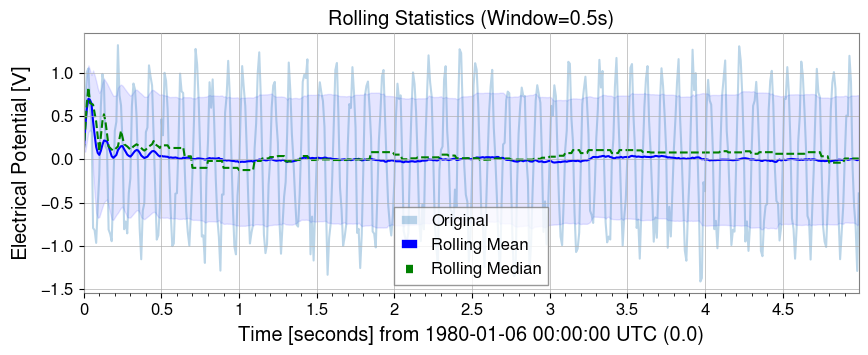

In [51]:
rw = 0.5 * u.s # 0.5秒窓
rmean = ts1.rolling_mean(rw)
rstd = ts1.rolling_std(rw)
rmed = ts1.rolling_median(rw)
rmin = ts1.rolling_min(rw)
rmax = ts1.rolling_max(rw)

plot = Plot(ts1, rmean, rmed, figsize=(10, 4))
ax = plot.gca()
ax.get_lines()[0].set_label('Original')
ax.get_lines()[0].set_alpha(0.3)
ax.get_lines()[1].set_label('Rolling Mean')
ax.get_lines()[1].set_color('blue')
ax.get_lines()[2].set_label('Rolling Median')
ax.get_lines()[2].set_color('green')
ax.get_lines()[2].set_linestyle('--')
ax.fill_between(rmean.times.value, rmean.value - rstd.value, rmean.value + rstd.value, alpha=0.1, color='blue')
ax.legend()
ax.set_title('Rolling Statistics (Window=0.5s)')
plt.show()

<a id="resampling"></a>
## 6. リサンプリングと再インデックス

`asfreq` メソッドによる固定グリッドへの割り当てや、`resample` メソッドでの「時間ビン集計」が可能になりました。

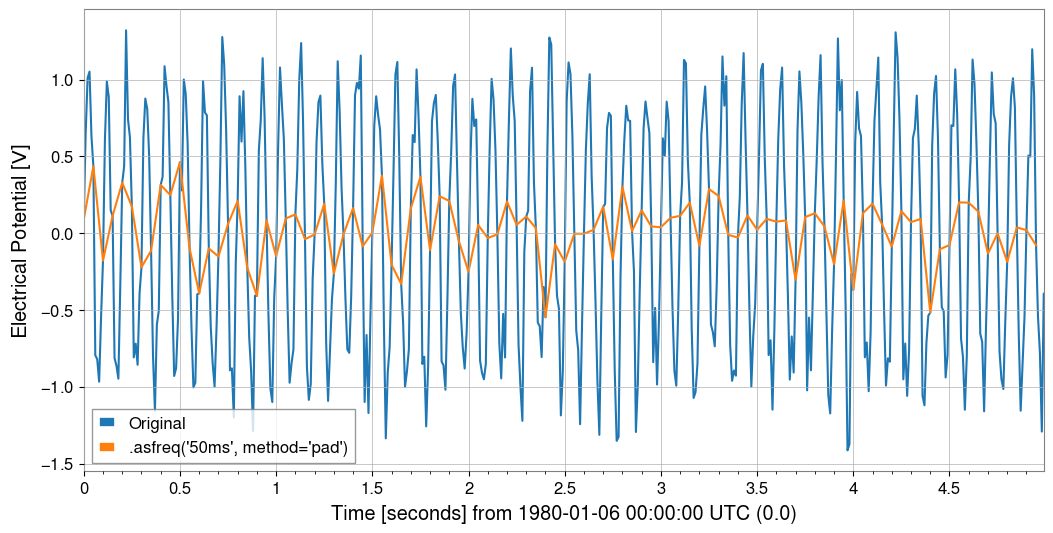

In [52]:
# 1. asfreq: Pandasライクな名付け規則 ('50ms' など) で再インデックス
ts_reindexed = ts1.asfreq('50ms', method='pad')
Plot(ts1, ts_reindexed)
plt.legend(['Original', ".asfreq('50ms', method='pad')"])

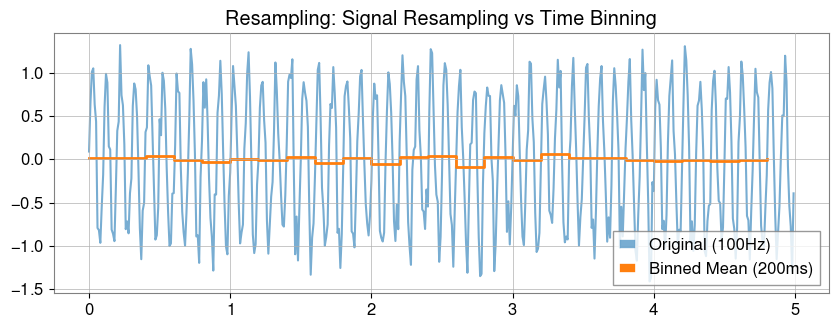

In [53]:
# 2. resample:
# 数値 (10Hz) を指定すると信号処理的なリサンプリング (GWpy標準)
ts_sig = ts1.resample(10)
# 文字列 ('200ms') を指定すると、その時間幅のビンごとの統計量をとる (新機能)
ts_binned = ts1.resample('200ms') # デフォルトは mean

# Plot doesn't have a direct 'step' method equivalent in args, so we use ax.step or pass to plot
# However, kwarg 'drawstyle'='steps-post' works in plot()? gwpy Plot wraps matplotlib.
# Let's assume we can modify axes after creation or use standard plot for simplicity if appropriate, but step is specific.
# Better strategy: Create Plot instance, then use ax.step
plot = Plot(figsize=(10, 4))
ax = plot.gca()
ax.plot(ts1, alpha=0.6, label='Original (100Hz)')
ax.step(ts_binned.times, ts_binned.value, where='post', label='Binned Mean (200ms)', linewidth=2)
ax.legend()
ax.set_title('Resampling: Signal Resampling vs Time Binning')
plt.show()

## 7. 関数によるフィッティング

`gwexpy` では `iminuit` をベースとした強力なフィッティング機能を提供しています。GWpy の元のクラスを汚染しないよう、`.fit()` メソッドはオプトイン方式になっています。

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.0005703 (χ²/ndof = 0.0)  │              Nfcn = 324              │
│ EDM = 0.000176 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

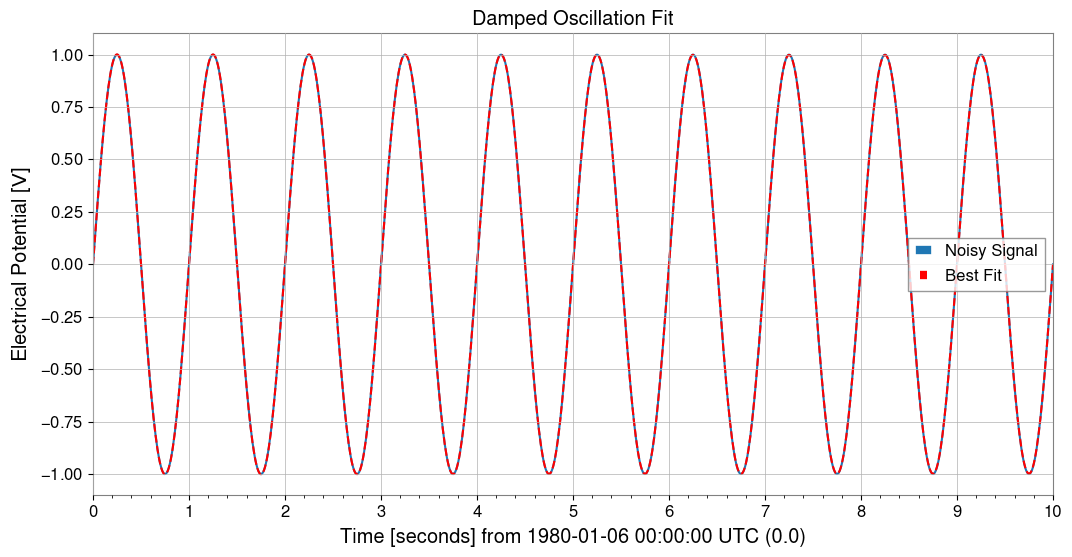

In [54]:
from gwexpy.fitting.models import damped_oscillation

# 減衰振動モデルでフィット (関数を直接渡す)
# 初期値: A=0.5, tau=0.5, f=15, phi=0
result = data.fit(damped_oscillation, A=0.5, tau=0.5, f=15, phi=0)

# 結果の表示 (iminuit形式)
print(result)

# ベストフィット曲線の取得
#注: x_data はデータ点に対応する時間の配列です
x_data = data.times.value
best_fit = result.model(x_data)

# プロット
plot = data.plot(label="Noisy Signal")
ax = plot.gca()
ax.plot(data.times, best_fit, label="Best Fit", color="red", linestyle="--")
ax.legend()
ax.set_title("Damped Oscillation Fit")
plt.show()


<a id="interop"></a>
## 8. 相互運用性

主要なデータサイエンス・機械学習ライブラリとの相互変換が非常にスムーズです。

In [55]:
# Pandas & Xarray
try:
    df = ts1.to_pandas(index='datetime')
    ts_p = TimeSeries.from_pandas(df)
    print("Pandas interop OK")
    display(df)
except ImportError: pass

try:
    xr = ts1.to_xarray()
    ts_xr = TimeSeries.from_xarray(xr)
    print("Xarray interop OK")
    display(xr)
except ImportError: pass


Pandas interop OK


time_utc
1980-01-06 00:00:19+00:00           0.089922
1980-01-06 00:00:19.010000+00:00    0.652089
1980-01-06 00:00:19.020000+00:00    1.010617
1980-01-06 00:00:19.030000+00:00    1.052631
1980-01-06 00:00:19.040000+00:00    0.633539
                                      ...   
1980-01-06 00:00:23.950000+00:00   -0.077873
1980-01-06 00:00:23.960000+00:00   -0.541948
1980-01-06 00:00:23.970000+00:00   -0.777539
1980-01-06 00:00:23.980000+00:00   -1.291722
1980-01-06 00:00:23.990000+00:00   -0.394123
Name: Sensor 1, Length: 500, dtype: float64

Xarray interop OK


<xarray.DataArray 'Sensor 1' (time: 500)> Size: 4kB
array([ 0.08992202,  0.65208885,  1.01061733, ..., -0.77753908,
       -1.29172239, -0.39412294])
Coordinates:
  * time     (time) datetime64[ns] 4kB 1980-01-06T00:00:19 ... 1980-01-06T00:...
Attributes:
    unit:        V
    name:        Sensor 1
    channel:     None
    epoch:       0.0
    time_coord:  datetime

In [56]:
# SQLite (シリアライズ保存)
import sqlite3
with sqlite3.connect(':memory:') as conn:
    ts1.to_sqlite(conn, series_id='my_sensor')
    ts_sql = TimeSeries.from_sqlite(conn, series_id='my_sensor')
    print(f"SQLite interop OK: {ts_sql.name}")
    display(conn)


SQLite interop OK: my_sensor


In [ ]:
# Deep Learning (Torch)
try:
    import torch
    t_torch = ts1.to_torch()
    ts_f_torch = TimeSeries.from_torch(t_torch, t0=ts1.t0, dt=ts1.dt)
    print(f"Torch interop OK (Shape: {t_torch.shape})")
    display(t_torch)
except ImportError: pass


In [ ]:
# Deep Learning (TensorFlow)
try:
    import tensorflow as tf
    t_tf = ts1.to_tensorflow()
    ts_f_tf = TimeSeries.from_tensorflow(t_tf, t0=ts1.t0, dt=ts1.dt)
    print("TensorFlow interop OK")
    display(t_tf)
except ImportError: pass


In [ ]:
# ObsPy (地震波形・時系列解析)
try:
    import obspy
    tr = ts1.to_obspy()
    ts_f_obspy = TimeSeries.from_obspy(tr)
    print(f"ObsPy interop OK: {tr.id}")
    display(tr)
except ImportError: pass


### まとめ

`gwexpy` の `TimeSeries` クラスは、従来の GWpy の使い勝手はそのままに、より現代的で広範な分析ニーズに応える機能を備えています。
是非、皆さんのプロジェクトで活用してください！